In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from math import pi

from load_spe import load_spe
import scipy.constants as const
from fit_lorentzian import fit_peak, lorentzian, voigt
# from ..utils_convolution import interp_nb
# from ..utils_general import get_I, get_I_conv

/home/zhantao/.conda/envs/sqt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
E_cutoff = 5.

loss =  0.46977360002803814
loc: tensor([10.3513, 13.6543]) 
amp: tensor([ 9.3341, 11.3251], dtype=torch.float64) 
gamma: tensor([0.9277, 0.6444]) 
sigma: tensor([0.0447, 0.6929])


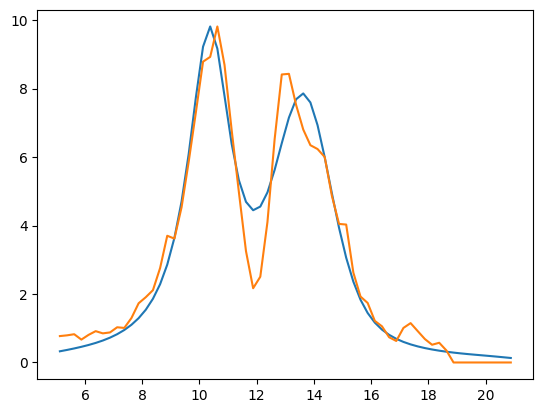

In [3]:
fname = 'fig3a1.spe'
HH0_raw, E_raw, Z_raw, Err_raw = load_spe(fname)
idx_K = np.argmin(np.abs(HH0_raw + 1/3))

E_K, Intens_K = E_raw[E_raw>E_cutoff], Z_raw[E_raw>E_cutoff,idx_K]

param_X0, param_A, param_G, param_sigma = fit_peak(torch.from_numpy(E_K), torch.from_numpy(Intens_K), numIters=2000,mode='voigt')
Intens_K_fitted = voigt(torch.from_numpy(E_K), param_X0, param_A, param_G, param_sigma).detach().numpy()
plt.plot(E_K, Intens_K_fitted)
plt.plot(E_K, Intens_K / Intens_K.max() * Intens_K_fitted.max())
print('\nloc:', param_X0.squeeze(), '\namp:', param_A.squeeze(), '\ngamma:', param_G.squeeze(), '\nsigma:', param_sigma.squeeze())

In [4]:
import sys
sys.path.append('../')
from utils_model import jit_batch_spec_to_Sqt

In [5]:
sigma_bkg = 1.0
w = torch.from_numpy(E_raw)
Sqw_bkg = 50 * torch.exp(-w.pow(2)/(2 * sigma_bkg**2)).detach().numpy()

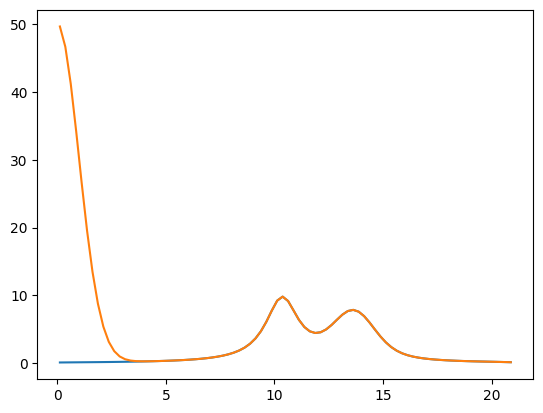

In [6]:
Sqw = voigt(w, param_X0, param_A, param_G, param_sigma).detach().numpy()
Sqw_tot = Sqw + Sqw_bkg
plt.plot(E_raw, Sqw)
plt.plot(E_raw, Sqw_tot)

In [7]:
Sqt = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw), torch.linspace(0,5,501)).sum(dim=1).squeeze()
Sqt_bkg = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw_bkg), torch.linspace(0,5,501)).sum(dim=1).squeeze()
Sqt_tot = jit_batch_spec_to_Sqt(w, torch.from_numpy(Sqw_tot), torch.linspace(0,5,501)).sum(dim=1).squeeze()

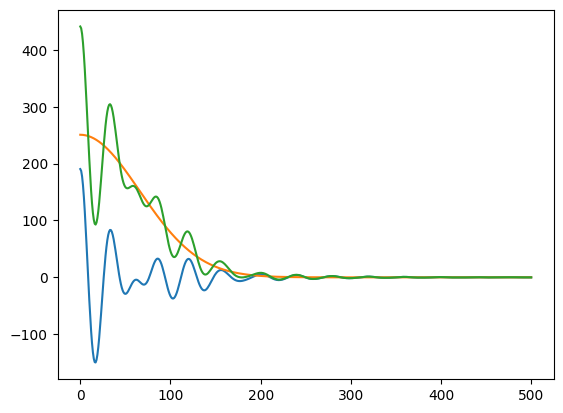

In [8]:
plt.plot(Sqt)
plt.plot(Sqt_bkg)
plt.plot(Sqt_tot)

In [14]:
from utils_convolution import interp_nb
from utils_general import get_I, get_I_conv
from utils_model import jit_batch_spec_to_Sqt

def prepare_CrI3_sample(times, pulse_width=0.2, std_increase_factor=1., amp_increase_factor=0., E_cutoff=5., N_samples=1000, S0_value=10, elas_bkg_amp=0., elas_bkg_wid=1.0):
    fname = 'fig3a1.spe'
    HH0_raw, E_raw, Z_raw, Err_raw = load_spe(fname)
    idx_K = np.argmin(np.abs(HH0_raw + 1/3))

    E_K, Intens_K = E_raw[E_raw>E_cutoff], Z_raw[E_raw>E_cutoff,idx_K]

    # param_X0, param_A, param_G = fit_lorentzian(torch.from_numpy(E_K), torch.from_numpy(Intens_K))
    # Intens_K_fitted = lorentzian(torch.from_numpy(E_K), param_X0, param_A, param_G).detach().numpy()
    param_X0, param_A, param_G, param_sigma = fit_peak(torch.from_numpy(E_K), torch.from_numpy(Intens_K), numIters=2000, mode='voigt')
    Intens_K_fitted = voigt(torch.from_numpy(E_K), param_X0, param_A, param_G, param_sigma).detach().numpy()
    plt.plot(E_K, Intens_K_fitted)
    plt.plot(E_K, Intens_K / Intens_K.max() * Intens_K_fitted.max())

    meV_to_2piTHz = 2 * np.pi * 1e-15 / const.physical_constants['hertz-electron volt relationship'][0]
    dt = times[1]-times[0]
    times_extended = np.arange(times[0]-pulse_width, times[-1]+pulse_width, dt)

    E_full = torch.from_numpy(E_raw)
    Sqw_mag = voigt(E_full, param_X0, param_A, param_G, param_sigma).detach()
    Sqt_mag = jit_batch_spec_to_Sqt(E_full, Sqw_mag, torch.from_numpy(times_extended)).sum(dim=1).squeeze()

    Sqw_bkg = elas_bkg_amp * torch.exp(-E_full.pow(2)/(2 * elas_bkg_wid**2)).detach()
    Sqt_bkg = jit_batch_spec_to_Sqt(E_full, Sqw_bkg, torch.from_numpy(times_extended)).sum(dim=1).squeeze()

    Sqt_tot = (Sqt_mag + Sqt_bkg).numpy()

    # get unconvolved interpolation function
    func_I_noconv = lambda t: interp_nb(t, times_extended, np.abs(Sqt_tot)**2)
    # get convolved interpolation function
    true_I_conv = get_I_conv(times, times_extended, Sqt_tot, pulse_width)
    true_I_conv = S0_value**2 * true_I_conv / true_I_conv[0]
    func_I_conv = lambda t: interp_nb(t, times, true_I_conv)
    fig, ax = plt.subplots(1,1)
    ax.plot(times_extended, np.abs(Sqt_tot)**2)
    ax.plot(times, true_I_conv)

    fig, axes = plt.subplots(1,2, sharey=True, gridspec_kw={'wspace': 0.0, 'width_ratios': [2, 1]})
    ax = axes[0]
    ax.imshow(np.log10(Z_raw), extent=[HH0_raw.min(), HH0_raw.max(), E_raw.min(), E_raw.max()], origin='lower')
    ax.vlines(-1/3, E_raw.min(), E_raw.max(), linestyles='--', colors='k')
    ax.set_aspect(2 * np.ptp(HH0_raw) / np.ptp(E_raw))
    ax.set_xlabel('$h$ for $[h=h, k=h, l=0]$')
    ax.set_ylabel('$E$ (eV)')
    ax = axes[1]
    ax.errorbar(Z_raw[E_raw>E_cutoff,idx_K], E_K, yerr=None, xerr=Err_raw[E_raw>E_cutoff, idx_K], color='k', ecolor='k')
    ax.plot(Intens_K_fitted / Intens_K_fitted.max() * Intens_K.max(), E_K, color='b', linestyle='--')
    ax.set_xticks([])
    ax.set_xlabel('Intensities (a.u.)')
    ax.set_ylim([0,20])

    return None, func_I_conv, func_I_noconv


ImportError: attempted relative import with no known parent package

RuntimeError: jit_batch_spec_to_Sqt() Expected a value of type 'Tensor (inferred)' for argument 'time' but instead found type 'ndarray'.
Inferred 'time' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 2
Value: array([-0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,
        0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,
        2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,
        3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,
        4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1])
Declaration: jit_batch_spec_to_Sqt(Tensor omega, Tensor inten, Tensor time, Tensor meV_to_2piTHz=1.51927
[ torch.FloatTensor{} ]) -> Tensor
Cast error details: Unable to cast [-0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1
  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5
  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9
  4.   4.1  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1] to Tensor

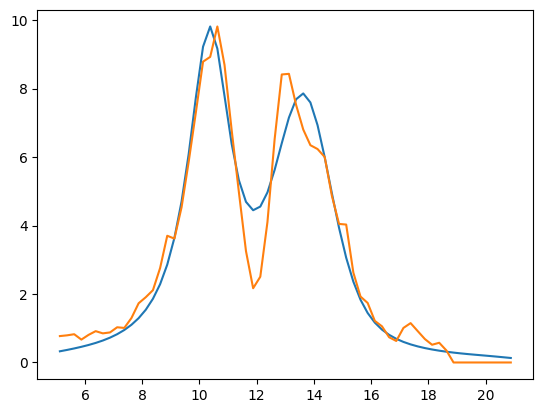

In [13]:
times = np.arange(0,5,0.1)
prepare_CrI3_sample(times)